In [2]:
import w4h
import pandas as pd
resources = w4h.get_resources(scope='local')
study_area = resources['study_area']
df = resources['well_data']
df = pd.read_csv(df)
df

,ID,API_NUMBER,TABLE_NAME,WHO,INTERPRET_DATE,FORMATION,THICKNESS,TOP,BOTTOM,ID.1,LATITUDE,LONGITUDE,ELEVATION,geometry
0,0,1.216330e+11,WFORMATIONS,NaN,NaN,clay & silty clay,15.0,0.0,15.0,377397,38.520278,-90.218333,396.538940,POINT (-90.218333 38.520278)
1,1,1.216330e+11,WFORMATIONS,NaN,NaN,sand,96.0,15.0,111.0,377397,38.520278,-90.218333,396.538940,POINT (-90.218333 38.520278)
2,2,1.216330e+11,WFORMATIONS,NaN,NaN,crushed rock,3.0,0.0,3.0,376978,38.520917,-90.213611,410.760956,POINT (-90.213611 38.520917)
3,3,1.216330e+11,WFORMATIONS,NaN,NaN,clay,4.0,3.0,7.0,378246,38.520917,-90.213611,410.760956,POINT (-90.213611 38.520917)
4,4,1.216330e+11,WFORMATIONS,NaN,NaN,brown & gray sand,9.0,18.0,27.0,376978,38.520917,-90.213611,410.760956,POINT (-90.213611 38.520917)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29800,29800,1.211923e+11,WFORMATIONS,NaN,NaN,dirt,3.0,0.0,3.0,311349,38.871681,-90.080792,436.866852,POINT (-90.080792 38.871681)
29801,29801,1.211923e+11,WFORMATIONS,NaN,NaN,coarse sand,15.0,25.0,40.0,311349,38.871681,-90.080792,436.866852,POINT (-90.080792 38.871681)
29802,29802,1.211923e+11,WFORMATIONS,NaN,NaN,sandy clay,8.0,5.0,13.0,311349,38.871681,-90.080792,436.866852,POINT (-90.080792 38.871681)
29803,29803,1.211923e+11,WFORMATIONS,NaN,NaN,rock at,0.0,94.0,94.0,311349,38.871681,-90.080792,436.866852,POINT (-90.080792 38.871681)


In [ ]:
model_ds = rxr.open_rasterio(resources['model_grid'])
len(model_ds[:, ::100, ::100].y) * len(model_ds[:, ::100, ::100].x)

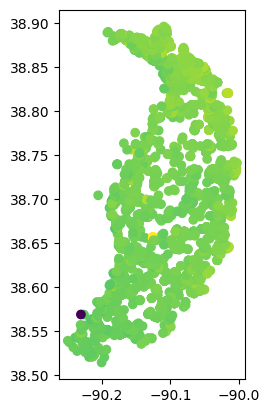

Starting interpolation at all grid points:  28 x 42 1176


In [ ]:
import datetime
import inspect
import numbers
import os
import pathlib

import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray as rxr
from scipy import interpolate
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely import Point, Polygon, wkt

import w4h
import pandas as pd
resources = w4h.get_resources(scope='local')
study_area = resources['study_area']
df = resources['well_data']
df = pd.read_csv(df)
df


def natural_neighbor_interp(points, model_grid=None, parallelize=False,
                            well_id='API_NUMBER', interp_value='ELEVATION',
                            xcoord='LONGITUDE', ycoord='LATITUDE', elev="ELEVATION",
                            show_points=False, sparsity_factor=10,
                            show_plot=False, show_adjacent_regions=False, show_voronoi=False,
                            time_segments=False, layers=None, ):
    time0 = datetime.datetime.now()
    model_grid_IN = rxr.open_rasterio(model_grid)
    
    interp_grid = model_grid_IN[:, ::sparsity_factor, ::sparsity_factor]
    interp_grid = interp_grid.rio.reproject(4326)

    uniqueWellDF = points.drop_duplicates(subset=well_id)[[well_id, xcoord, ycoord, elev, 'geometry']].reset_index(drop=True)
    
    uniqueWellDF['geometry'] = uniqueWellDF['geometry'].apply(wkt.loads)
    uniqueWellDF = gpd.GeoDataFrame(uniqueWellDF, geometry='geometry', crs=4326)
    
    minx, miny, maxx, maxy = uniqueWellDF.total_bounds
    interp_grid = interp_grid.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)
    
    wellPtList = []
    wellValueList = []
    valueField = 'ELEVATION'
    for i, well in uniqueWellDF.iterrows():
        wellPtList.append([well['LONGITUDE'], well["LATITUDE"]])
        wellValueList.append(float(well[valueField]))
    wellPtArr = np.array(wellPtList)

    if show_points:
        uniqueWellDF.plot(c=uniqueWellDF[interp_value], vmin=400, vmax=600)#xcoord, ycoord, kind='scatter')
        plt.show()

    wellPtList = []
    wellValueList = []
    for i, well in uniqueWellDF.iterrows():
        wellPtList.append([well[xcoord], well[ycoord]])
        wellValueList.append(float(well[interp_value]))

    vClass = Voronoi(points=wellPtArr)
    if time_segments:
        thisTime = lastTime = datetime.datetime.now()
        print(f"Voronoi time:  {thisTime-time0}")

    if show_voronoi:
        voronoi_plot_2d(vClass)
        plt.show()

    # Get vertices as variable
    verts = vClass.vertices

    # Iterate through all coordinates for interpolation
    # CODE HERE FOR ITERATING THROUGH COORDS?
    newPoint = Point([-90.1, 38.7])
    
    def _vectorized_nat_neighbor(x, y, time_segments=time_segments):
        newPoint = Point([x, y])
        lastTime = datetime.datetime.now()

        wgs84Pt = gpd.GeoSeries([newPoint], crs=4326).to_crs(4326)
        
        # Find region containing the "newPoint" (point for interpolation)
        polygonList = []
        polyRegInd = []
        containingRegion = None
        for i, region in enumerate(vClass.regions):
            # Create (valid) shapely polygon for each region using vertices
            vertList = [verts[v].tolist() for v in region if v != -1]
            if len(vertList) > 0 and vertList[0] != vertList[-1]:
                vertList.append(vertList[0])

            if len(vertList) == 0:
                continue
            currPoly = Polygon(vertList)

            # If polygon contains the point, record and break loop
            if currPoly.is_valid and currPoly.contains(newPoint) and containingRegion is None:
                containingRegion = currPoly
                containingRegionIndex = i
                break
            polygonList.append(currPoly)
            polyRegInd.append(i)

        if containingRegion is None:
            #print("Polygon is invalid or no overlapping polygons with point")
            return np.nan

        if time_segments:
            thisTime = datetime.datetime.now()
            print(f"Make Initial Polygons time:  {thisTime-lastTime}")
            lastTime = datetime.datetime.now()

        # Get all regions that touch containing region
        # UPDATE THIS WITH GEOPANDAS FOR EFFICIENCY!!!!!!
        regionAndAdjacents = [containingRegion]
        regionIndices = [containingRegionIndex]
        for i, region in enumerate(polygonList):
            touchCondition = containingRegion.touches(region)

            if touchCondition:
                regionAndAdjacents.append(region)
                regionIndices.append(polyRegInd[i])

        # Now, get second layer of regions
        # UPDATE THIS WITH GEOPANDAS FOR EFFICIENCY!!!!!!
        regionAndAdjacents2 = regionAndAdjacents.copy()
        for i, region in enumerate(regionAndAdjacents2):
            for j, regInd in enumerate(vClass.point_region):
                regionVerts = [verts[v].tolist() for v in vClass.regions[regInd]]
                currPoly = Polygon(regionVerts)
                if region.touches(currPoly) and currPoly.is_valid and regInd not in regionIndices:
                    regionAndAdjacents.append(currPoly)
                    regionIndices.append(int(regInd))

        if time_segments:
            thisTime = datetime.datetime.now()
            print(f"Get all adjacent and semi-adjacent Polygons:  {thisTime-lastTime}")
            lastTime = datetime.datetime.now()

        # Get points and values for interpolation
        nearPoints = [newPoint.coords[0]]
        nearValues = [None]
        vPR = list(vClass.point_region)
        for ind in regionIndices:
            nearValues.append(wellValueList[vPR.index(ind)])
            nearPoints.append(vClass.points[vPR.index(ind)].tolist())
        regGS = gpd.GeoDataFrame(zip(regionIndices, regionAndAdjacents), columns=['RegionIndices', 'geometry'], crs=4326)

        if time_segments:
            thisTime = datetime.datetime.now()
            print(f"Extract points for interpolation:  {thisTime-lastTime}")
            lastTime = datetime.datetime.now()

        # Plot regions and points
        if show_adjacent_regions:
            x, y = zip(*nearPoints)
            fig, ax = plt.subplots(figsize=(10,10))
            ax.scatter(x, y, c=nearValues)

            regGS.plot(ax=ax, facecolor='#00000000', edgecolor='k')
            ax.scatter(x=newPoint.xy[0], y=newPoint.xy[1], c='k', marker='+')
            [ax.text(x=x[i], y=y[i], s=f"{nv:.0f}") for i, nv in enumerate(nearValues) if i!=0]
            plt.show()
            if time_segments:
                thisTime = datetime.datetime.now()
                print(f"Plot adjacent regions:  {thisTime-lastTime}")
                lastTime = datetime.datetime.now()

        # Create new voronoi only with points with regions nearby to new point (to reduce computational cost)
        nearbyVor = Voronoi(points=nearPoints)
        if time_segments:
            thisTime = datetime.datetime.now()
            print(f"Generate near voronoi:  {thisTime-lastTime}")
            lastTime = datetime.datetime.now()

        # Go through just the nearby regions, check validitiy, and get info
        # (Might be able to just access with indices and save time?)
        polygons = []
        for i, region in enumerate(nearbyVor.regions):
            # Create (valid) shapely polygon for each region using vertices
            vertList = [verts[v].tolist() for v in region]

            if len(vertList)>0 and vertList[0] != vertList[-1]:
                vertList.append(vertList[0])

            if len(vertList)<4:
                continue
            
            currPoly = Polygon(vertList)

            # If polygon contains the point, record and break loop
            if currPoly.is_valid and currPoly.contains(newPoint) and containingRegion is False:
                containingRegion = currPoly
                containingRegionIndex = i
            polygons.append(currPoly)
            polyRegInd.append(i)

        if time_segments:
            thisTime = datetime.datetime.now()
            print(f"Get nearby polygons:  {thisTime-lastTime}")
            lastTime = datetime.datetime.now()

        # Get the "New" polygon (the one created for the interpolation point of interest)
        try:
            polyOfInterest = Polygon([nearbyVor.vertices[v] for v in nearbyVor.regions[nearbyVor.point_region[0]]])
        except:
            return np.nan
        
        if not polyOfInterest.is_valid:
            #print('Polygon of interest is not valid')
            return np.nan

        # Plot regions nearby point of interest, and overlap of new Voronoi and old
        if show_plot:
            fig3, ax3 = plt.subplots()
            regGS.plot(facecolor="#00000000", edgecolor='k', ax=ax3)
            x, y = zip(*nearPoints)
            ax3.scatter(x, y)
            gpd.GeoSeries([polyOfInterest], crs=4326).plot(facecolor="#00000000", 
                                                        edgecolor='r', linewidths=5, ax=ax3)
            if time_segments:
                thisTime = datetime.datetime.now()
                print(f"Plot nearby polys and overlap:  {thisTime-lastTime}")
                lastTime = datetime.datetime.now()
            plt.show()
            
        # Check which regions overlap and their areas
        intersectionAreas = []
        intersectionValues = []
        for row, reg in regGS.iterrows():
            if reg['geometry'].intersects(polyOfInterest):
                intersectionAreas.append(polyOfInterest.intersection(reg['geometry']).area)
                intersectionValues.append(float(wellValueList[vPR.index(reg['RegionIndices'])]))            

        # Calculate weights
        weights = np.array(intersectionAreas)/np.nansum(intersectionAreas)
        if time_segments:
            thisTime = datetime.datetime.now()
            print(f"Calculate weights:  {thisTime-lastTime}")
            lastTime = datetime.datetime.now()

        res = float(np.nansum(weights * intersectionValues))
        # Calculate and return natural neighbor interpolated value
        return res

    if parallelize: 
        x = interp_grid["x"].values
        y = interp_grid["y"].values

        da_x = xr.DataArray(x, dims="x", coords={"x": x})
        da_y = xr.DataArray(y, dims="y", coords={"y": y})

        # Broadcast to full grid
        X, Y = xr.broadcast(da_x, da_y)

        # Apply function vectorized over coordinates
        result_vec = xr.apply_ufunc(
            _vectorized_nat_neighbor, X, Y,
            vectorize=True,
            #dask="parallelized", # optional if using dask
            output_dtypes=[float]        
            )

        print(interp_grid)
        print(result_vec)

        return xr.DataArray(result_vec.T,
                            coords={"y": interp_grid.y, "x": interp_grid.x},
                            dims=("y", "x"))
    else:
        print("Starting interpolation at all grid points: ", len(interp_grid['x'].values), 'x', len(interp_grid['y'].values), len(interp_grid['y'].values)*len(interp_grid['x'].values))
        resultList = []
        for x in interp_grid['x'].values:
            innerList = []
            for y in interp_grid['y'].values:
                interpVal = _vectorized_nat_neighbor(x, y, time_segments=time_segments)
                innerList.append(interpVal)
            resultList.append(innerList)
    
    
        print("Final Size:", np.array(resultList).shape)
        return xr.DataArray(np.array(resultList).T,
                            coords={"y": interp_grid.y, "x": interp_grid.x},
                            dims=("y", "x"))
        nnInterp.interp_like(model_grid)


natNeighborInterpDA = natural_neighbor_interp(points=df, model_grid=resources['model_grid'], 
                                              sparsity_factor=5, show_adjacent_regions=False,
                                              parallelize=False, time_segments=False,
                                              show_points=True, show_voronoi=False)

<Axes: xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

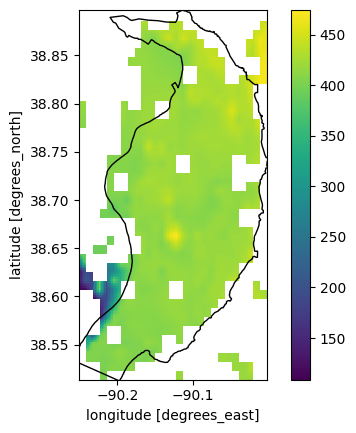

In [ ]:

uniqueWellDF = df.drop_duplicates(subset='API_NUMBER')[['API_NUMBER', "LONGITUDE", 'LATITUDE', 'ELEVATION', 'geometry']].reset_index(drop=True)

uniqueWellDF['geometry'] = uniqueWellDF['geometry'].apply(wkt.loads)
uniqueWellDF = gpd.GeoDataFrame(uniqueWellDF, geometry='geometry', crs=4326)
minx, miny, maxx, maxy = uniqueWellDF.total_bounds

model_grid = rxr.open_rasterio(resources['model_grid']).rio.reproject(4326)
clipGrid = model_grid.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)

fig, ax = plt.subplots()
natNeighborInterpDA.interp({'x':clipGrid.coords.x.values, 'y':clipGrid.coords.y.values}, method='linear').plot(ax=ax)
gpd.read_file(resources['study_area']).to_crs(4326).plot(ax=ax, facecolor='#00000000', edgecolor='k')

In [ ]:
uniqueWellDF = df.drop_duplicates(subset='API_NUMBER')[["API_NUMBER", 'LATITUDE', "LONGITUDE", "ELEVATION"]].reset_index(drop=True)
uniqueWellDF.plot('LONGITUDE', "LATITUDE", kind='scatter')

In [ ]:
rxr.open_rasterio(resources['model_grid'])

In [ ]:
import numpy as np
wellPtList = []
wellValueList = []
valueField = 'ELEVATION'
for i, well in uniqueWellDF.iterrows():
    wellPtList.append([well['LONGITUDE'], well["LATITUDE"]])
    wellValueList.append(float(well[valueField]))
wellPtArr = np.array(wellPtList)

In [ ]:
from scipy.spatial import Voronoi
from shapely import Point, Polygon
import shapely
import shapely.ops
import shapely.geometry
from scipy.spatial import voronoi_plot_2d
import matplotlib.pyplot as plt
import geopandas as gpd
import datetime

def natural_neighbor_interp(points, show_plot=False, show_adjacent_regions=False, time_segments=False, model_grid=None, layers=None, ):
    time0 = datetime.datetime.now()
    vClass = Voronoi(points=points)
    if time_segments:
        thisTime = lastTime = datetime.datetime.now()
        print(f"Voronoi time:  {thisTime-time0}")

    verts = vClass.vertices

    # Different way to create polygons (using ridges), but has a different number of regions
    #lines = [
    #shapely.geometry.LineString(vClass.vertices[line])
    #for line in vClass.ridge_vertices #if -1 not in line
    #]
    #polygons = list(shapely.ops.polygonize(lines))
    #print(len(vClass.points), len(polygons), len(vClass.vertices), len(vClass.point_region), len(vClass.regions), len(vClass.ridge_vertices))

    # This will eventually iterate over all raster coordinates
    newPoint = Point([-90.1, 38.7])

    # Find region containing the "newPoint" (point for interpolation)
    polygonList = []
    polyRegInd = []
    containingRegion = False
    for i, region in enumerate(vClass.regions):
        # Create (valid) shapely polygon for each region using vertices
        vertList = [verts[v].tolist() for v in region if v!=-1]
        
        if len(vertList)>0 and vertList[0] != vertList[-1]:
            vertList.append(vertList[0])

        if len(vertList)==0:
            continue
        currPoly = Polygon(vertList)
        
        # If polygon contains the point, record and break loop
        if currPoly.is_valid and currPoly.contains(newPoint) and containingRegion is False:
            containingRegion = currPoly
            containingRegionIndex = i
        polygonList.append(currPoly)
        polyRegInd.append(i)

    if time_segments:
        thisTime = datetime.datetime.now()
        print(f"Make Initial Polygons time:  {thisTime-lastTime}")
        lastTime = datetime.datetime.now()

    # Get all regions that touch containing region
    regionAndAdjacents = [containingRegion]
    regionIndices = [containingRegionIndex]
    for i, region in enumerate(polygonList):
        touchCondition = containingRegion.touches(region)#olygon([verts[v] for v in region if v != -1]))
        # Add an adjacent condition? (region that touches a touching region)
        if touchCondition:
            regionAndAdjacents.append(region)#Polygon([verts[v] for v in region if v != -1]))
            regionIndices.append(polyRegInd[i])

    # Now, get second layer of regions
    regionAndAdjacents2 = regionAndAdjacents.copy()
    for i, region in enumerate(regionAndAdjacents2):
        for j, regInd in enumerate(vClass.point_region):
            regionVerts = [verts[v].tolist() for v in vClass.regions[regInd]]
            currPoly = Polygon(regionVerts)
            if region.touches(currPoly) and regInd not in regionIndices:
                #if region.touches(newRegion) and j not in regionIndices:
                #regionAndAdjacents.append(Polygon([verts[v] for v in newRegion if v != -1]))
                regionAndAdjacents.append(currPoly)
                regionIndices.append(int(regInd))

    if time_segments:
        thisTime = datetime.datetime.now()
        print(f"Get all adjacent and semi-adjacent Polygons:  {thisTime-lastTime}")
        lastTime = datetime.datetime.now()

    # Get points and values for interpolation
    nearPoints = [newPoint.coords[0]]
    nearValues = [None]
    vPR = list(vClass.point_region)
    for ind in regionIndices:
        nearValues.append(wellValueList[vPR.index(ind)])
        nearPoints.append(vClass.points[vPR.index(ind)].tolist())
    regGS = gpd.GeoDataFrame(zip(regionIndices, regionAndAdjacents), columns=['RegionIndices', 'geometry'], crs=4326)

    if time_segments:
        thisTime = datetime.datetime.now()
        print(f"Extract points for interpolation:  {thisTime-lastTime}")
        lastTime = datetime.datetime.now()

    # Plot regions and points
    if show_adjacent_regions:
        x, y = zip(*nearPoints)
        fig, ax = plt.subplots(figsize=(10,10))
        ax.scatter(x, y, c=nearValues)

        #[reg.plot(ax=ax) for reg in regionAndAdjacents2]
        regGS.plot(ax=ax, facecolor='#00000000', edgecolor='k')
        ax.scatter(x=newPoint.xy[0], y=newPoint.xy[1],c='k', marker='+')
        [ax.text(x=x[i], y=y[i], s=f"{nv:.0f}") for i, nv in enumerate(nearValues) if i!=0]
        plt.show()
        if time_segments:
            thisTime = datetime.datetime.now()
            print(f"Plot adjacent regions:  {thisTime-lastTime}")
            lastTime = datetime.datetime.now()

    # Create new voronoi only with points with regions nearby to new point (to reduce computational cost)
    nearbyVor = Voronoi(points=nearPoints)
    if time_segments:
        thisTime = datetime.datetime.now()
        print(f"Generate near voronoi:  {thisTime-lastTime}")
        lastTime = datetime.datetime.now()

    # Go through just the nearby regions, check validitiy, and get info
    # (Might be able to just access with indices and save time?)
    polygons = []
    for i, region in enumerate(nearbyVor.regions):
        # Create (valid) shapely polygon for each region using vertices
        vertList = [verts[v].tolist() for v in region if v!=-1]
        
        if len(vertList)>0 and vertList[0] != vertList[-1]:
            vertList.append(vertList[0])

        if len(vertList)==0:
            continue
        currPoly = Polygon(vertList)
        
        # If polygon contains the point, record and break loop
        if currPoly.is_valid and currPoly.contains(newPoint) and containingRegion is False:
            containingRegion = currPoly
            containingRegionIndex = i
        polygons.append(currPoly)
        polyRegInd.append(i)

    if time_segments:
        thisTime = datetime.datetime.now()
        print(f"Get nearby polygons:  {thisTime-lastTime}")
        lastTime = datetime.datetime.now()


    #use_polygonize=False
    #if use_polygonize:
    #    lines = [
    #    shapely.geometry.LineString(nearbyVor.vertices[line])
    #    for line in nearbyVor.ridge_vertices if -1 not in line
    #    ]
    #    polygons = list(shapely.ops.polygonize(lines))

    # Get the "New" polygon (the one created for the interpolation point of interest)
    polyOfInterest = Polygon([nearbyVor.vertices[v] for v in nearbyVor.regions[nearbyVor.point_region[0]]])

    # Generate polygons from the LineString objects

    if show_plot:
        fig3, ax3 = plt.subplots()
        regGS.plot(facecolor="#00000000", edgecolor='k', ax=ax3)
        x, y = zip(*nearPoints)
        ax3.scatter(x, y)
        gpd.GeoSeries([polyOfInterest], crs=4326).plot(facecolor="#00000000", 
                                                    edgecolor='r', linewidths=5, ax=ax3)
        if time_segments:
            thisTime = datetime.datetime.now()
            print(f"Plot nearby polys and overlap:  {thisTime-lastTime}")
            lastTime = datetime.datetime.now()
        
        
    # Check which regions overlap and their areas
    intersectionAreas = []
    intersectionValues = []
    for row, reg in regGS.iterrows():
        if reg['geometry'].intersects(polyOfInterest):
            intersectionAreas.append(polyOfInterest.intersection(reg['geometry']).area)
            intersectionValues.append(float(wellValueList[vPR.index(reg['RegionIndices'])]))            
    
    # Calculate weights
    weights = np.array(intersectionAreas)/np.sum(intersectionAreas)
    
    if time_segments:
        thisTime = datetime.datetime.now()
        print(f"Calculate weights:  {thisTime-lastTime}")
        lastTime = datetime.datetime.now()
    
    
    # Calculate and return natural neighbor interpolated value
    return float(np.sum(weights * intersectionValues))
    #return Voronoi(points=points)

natural_neighbor_interp(points=wellPtArr, show_plot=False, time_segments=True, show_adjacent_regions=False, model_grid=None, layers=None, )

In [ ]:
vClass.point_region

In [ ]:
from shapely import Point, Polygon
import matplotlib.pyplot as plt
import geopandas as gpd
fig, ax = plt.subplots(figsize=(10,10))

geomList = []
verts = vClass.vertices
for region in vClass.regions:
    if len(region)>0:
        #region.append(region[0])

        currPoly = Polygon([verts[v] for v in region])
        if currPoly.is_valid:
            geomList.append(currPoly)

saCoords = Polygon([Point([-90.14341, 38.76749]), Point([-90.05592, 38.71129]), Point([-90.10095, 38.64567]), Point([-90.17643, 38.70627])])

sa = gpd.read_file(resources['study_area']).to_crs(4326)
test = gpd.GeoSeries(geomList, crs=4326)
test = test.clip(sa)
test.plot(edgecolor='k', ax=ax, facecolor="#00000000")
ax.scatter(x=uniqueWellDF['LONGITUDE'], y=uniqueWellDF['LATITUDE'], s=0.5)
